In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler       # scaling data

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

In [14]:
# read in the dataset
data = pd.read_csv('housing.csv',encoding='cp1252')
data.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [15]:
# Cleaning up data

# Filter out unqualified columns
data = data.drop(['longitude', 'latitude', 'ocean_proximity'], axis=1)

# Drop rows with null values
def filter_nulls(data):
    for column in data.columns:
        data = data[data[column].notnull()]   
    return data
data = filter_nulls(data)
data.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [16]:
# convert datatype to integer
data['housing_median_age']=data['housing_median_age'].astype('int64')
data['total_rooms']=data['total_rooms'].astype('int64')
data['total_bedrooms']=data['total_bedrooms'].astype('int64')
data['population']=data['population'].astype('int64')
data['households']=data['households'].astype('int64')
data['median_income']=data['median_income'].astype('int64')
data['median_house_value']=data['median_house_value'].astype('int64')


In [17]:
def correlation(dataset):
    """plot each variable to find their relationship with totalPrice
    """ 
    plt.figure(figsize = (30, 30))
    sns.heatmap(dataset.corr(), annot=True, fmt='1f')
    plt.title('California (1990)')
    plt.show()


In [20]:
new_data = data[['housing_median_age', 'total_rooms', 'population', 'households', 'median_income', 'median_house_value']]

In [21]:
# Split data into test and training data with a test size of 30% (.3)
from sklearn.model_selection import train_test_split # typically done at the start
train_features, test_features, train_outcome, test_outcome = train_test_split(
    new_data.drop('median_house_value', axis=1), # features
    new_data.median_house_value, # outcome
    random_state = 1,
    test_size=0.3 # percentage of data to use as the test set
)

In [22]:
def month(dataset):
    """distribution of the average housing transaction price (unit is 10k) each month
    """
    price_month = dataset.groupby('month').mean()
    plt.bar(price_month.index, price_month.totalPrice)
    plt.xlabel('Month')
    plt.ylabel('Average House Transaction Price (unit 10k)')
    plt.title('Monthly Distribution of Average House Transaction Price for Beijing' )
    plt.show()


In [23]:
def year(dataset):
    """distribution of the average housing transaction price (unit is 10k) each year
    """
    price_year = dataset.groupby('year').mean()
    plt.bar(price_year.index, price_year.totalPrice)
    plt.xlabel('Year')
    plt.ylabel('Average House Transaction Price (unit 10k)')
    plt.title('Yearly Distribution of Average House Transaction Price for Beijing' )
    plt.show()


In [24]:
def price(dataset):
    """distribution of the housing transaction price (unit is 10k) 
    """
    plt.hist(dataset.totalPrice)
    plt.xlabel('Transaction price (unit 10k)')
    plt.ylabel('Number of Transaction Occurs at this Price')
    plt.title('Distribution of the housing transaction price for Beijing' )
    plt.show()


In [25]:
def square_corr(dataset):
    """relationship between the square of a house and its housing transaction price (unit is 10k)
    """
    plt.scatter(dataset.square, dataset.totalPrice, alpha = .3)
    plt.xlabel('Square of the House')
    plt.ylabel('House Transaction Price (unit 10k)')
    plt.title('Relationship between square of the house and its transaction price')
    plt.show()



In [26]:
# Polynomial for better fit the data
poly = PolynomialFeatures()
dscoring = 'neg_mean_absolute_error'
folds = KFold(n_splits=10, shuffle=True, random_state=11)

In [27]:
# Ridge Regressor
rid = Ridge()
ripipe = make_pipeline(poly, rid)

riparams = {
            'polynomialfeatures__degree':range(1, 3),
            'ridge__alpha': [.001, 0.1, 1.0]
}
grid_rid = GridSearchCV(ripipe, riparams, scoring=dscoring, verbose=0, cv=folds, return_train_score=True)
grid_rid.fit(train_features, train_outcome)
rid_pred = grid_rid.predict(test_features)
grid_rid.score(test_features, test_outcome)

-55264.36520269901

In [28]:
# KNN Regressor
from sklearn.neighbors import KNeighborsRegressor    # regressor

scaler = MinMaxScaler()
knn = KNeighborsRegressor()
# Create a grid search estimator 
param_grid_knn={'polynomialfeatures__degree':range(1, 3),
                'kneighborsregressor__n_neighbors': range(1, 3),
                'kneighborsregressor__weights':['uniform', 'distance']}
pipeline_knn = make_pipeline(poly, scaler, knn)
#search the parameter grid using cross validation (across 10 different splits of the data)
grid_knn = GridSearchCV(pipeline_knn, param_grid_knn, scoring=dscoring, verbose=0, cv=folds, return_train_score=True) 
grid_knn.fit(train_features, train_outcome)
knn_pred = grid_knn.predict(test_features)
grid_knn.score(test_features, test_outcome)


-61323.044045677

In [29]:
# SGD Regressor
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()

sgparams = {
            'sgdregressor__loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
            'sgdregressor__penalty': ['none', 'l2', 'l1', 'elasticnet'], # l1 and elasticnet penalty does feature selection
            'sgdregressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
            'sgdregressor__learning_rate': ['optimal', 'invscaling'] # invscaling is default for regression
}

pipeline_sgd = make_pipeline(poly, sgd)

grid_sgd = GridSearchCV(pipeline_sgd, sgparams, scoring=dscoring, verbose=0, cv=folds, return_train_score=True)
grid_sgd.fit(train_features, train_outcome)
sgd_pred = grid_sgd.predict(test_features)
grid_sgd.score(test_features, test_outcome)


-68847270.1791024

In [30]:
# Dataframe of residuals and predictions of three models with a column of real prices
predictions_df= pd.DataFrame({'Ridge': rid_pred, 'KNN': knn_pred, 'SGD': sgd_pred,
                              'Ridge_res':test_outcome-rid_pred, 'KNN_res': test_outcome-knn_pred, 
                              'SGD_res': test_outcome-sgd_pred, 'realPrices': test_outcome})



Text(0.5, 1.0, 'Residuals of Ridge Models and the Real Transaction Prices vs. Ridge Predicted Transaction Price')

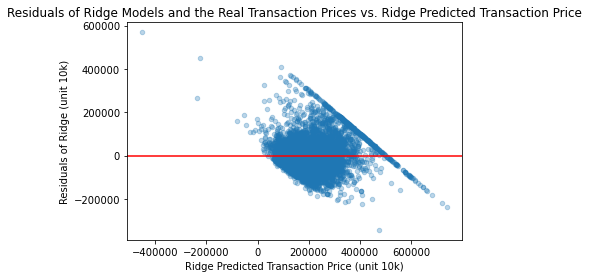

In [31]:
# Plot of Residuals of Ridge
predictions_df.plot(kind='scatter', x='Ridge', y='Ridge_res', alpha = .3);
plt.axhline(0, color='r')


plt.ylabel('Residuals of Ridge (unit 10k)')
plt.xlabel('Ridge Predicted Transaction Price (unit 10k)')
plt.title('Residuals of Ridge Models and the Real Transaction Prices vs. Ridge Predicted Transaction Price')


Text(0.5, 1.0, 'Residuals of KNN Models and the Real Transaction Prices vs. KNN Predicted Transaction Price')

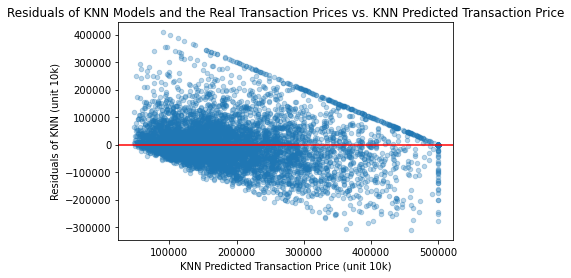

In [32]:
# Plot of Residuals of KNN
predictions_df.plot(kind='scatter', x='KNN', y='KNN_res', alpha = .3);
plt.axhline(0, color='r')

plt.ylabel('Residuals of KNN (unit 10k)')
plt.xlabel('KNN Predicted Transaction Price (unit 10k)')
plt.title('Residuals of KNN Models and the Real Transaction Prices vs. KNN Predicted Transaction Price')



Text(0.5, 1.0, 'Residuals of SGD Models and the Real Transaction Prices vs. SGD Predicted Transaction Price')

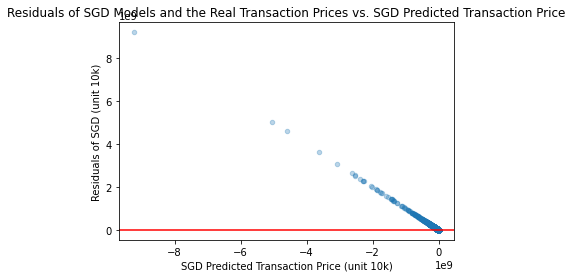

In [33]:
# Plot of Residuals of SGD
predictions_df.plot(kind='scatter', x='SGD', y='SGD_res', alpha = .3);
plt.axhline(0, color='r')

plt.ylabel('Residuals of SGD (unit 10k)')
plt.xlabel('SGD Predicted Transaction Price (unit 10k)')
plt.title('Residuals of SGD Models and the Real Transaction Prices vs. SGD Predicted Transaction Price')


Text(0.5, 1.0, 'Relationship between the predictions from models and the real transaction prices')

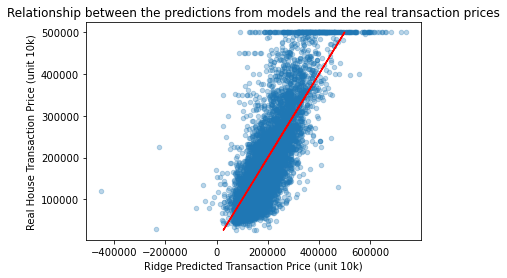

In [34]:
# Plot of Ridge Predicted Transaction Price vs. Real House Transaction Price
predictions_df.plot(kind='scatter', x='Ridge', y='realPrices', alpha = .3);
plt.plot(predictions_df.realPrices, predictions_df.realPrices, c='r')

plt.xlabel('Ridge Predicted Transaction Price (unit 10k)')
plt.ylabel('Real House Transaction Price (unit 10k)')
plt.title('Relationship between the predictions from models and the real transaction prices')
